# Multi-Label Classification

## 1. Imports

In [42]:
import pickle
import random
import re
import string
from collections import Counter
from pathlib import Path
from typing import Any, Union, Optional, Callable

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import asarray
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from wordcloud import WordCloud
from xgboost import XGBClassifier

from BRClassifier import BRClassifier
from CCClassifier import CCClassifier
from CDNClassifier import CDNClassifier
from CLRClassifier import CLRClassifier
from HOMERClassifier import HOMERClassifier
from LPClassifier import LPClassifier
from MBRClassifier import MBRClassifier
from PStClassifier import PStClassifier
from RAkELClassifier import RAkELClassifier

## 2. Configurations & Constants

### Global Configuration Constants

In [2]:
OVERWRITE = False
RETRAIN = False
RANDOM_STATE = 42
MODEL_LEVEL = 'general'

### Set Random Seeds

In [3]:
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

### Testing Parameters

In [4]:
TEST_SIZE = 2e-1

### Category Mappings

In [5]:
FIX_TARGETS = {
    'computer security': 'computer security',
    'operating systems': 'operating systems',
    'software': 'software',
    'programming languages': 'software',
    'hardware': 'hardware',
    'electronic components': 'hardware',
    'networking': 'networking',
    'internet technology': 'networking'
}

### Directory Paths

In [6]:
COLAB_DIR = Path('/content/drive/MyDrive')
KAGGLE_DIR = Path('/kaggle/input')
LOCAL_DIR = Path('./')

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import kaggle_secrets

    IN_KAGGLE = True
except ImportError:
    IN_KAGGLE = False

if IN_COLAB:
    DATA_DIR = COLAB_DIR / 'data'
    MODELS_DIR = COLAB_DIR / 'models'
elif IN_KAGGLE:
    DATA_DIR = KAGGLE_DIR
    MODELS_DIR = KAGGLE_DIR
else:
    DATA_DIR = LOCAL_DIR / 'data'
    MODELS_DIR = LOCAL_DIR / 'models'

### Dataset & Model Paths

In [7]:
GLOVE_DIR = MODELS_DIR / 'glove-embeddings'
GLOVE_6B_300D_TXT = GLOVE_DIR / 'glove.6B.300d.txt'

DATASET_DIR = DATA_DIR / 'tweets-dataset-for-cyberattack-detection'
TWEETS_PKL = DATASET_DIR / 'sub_tweets_train.pkl'

GENERAL_PKL = MODELS_DIR / 'general.pkl'

## 3. Data Loading & Preprocessing

Load the dataset, inspect its structure, and preprocess it for machine learning models.
For the goal of the project, the categories of interest are:
1. computer security/network security
2. computer security/antivirus and malware
3. operating systems/mac os
4. operating systems/windows
5. operating systems/unix
6. operating systems/linux
7. software
8. programming languages, included in software
9. software/databases
10. hardware
11. electronic components, included in hardware
12. hardware/computer/servers
13. hardware/computer/portable computer
14. hardware/computer/desktop computer
15. hardware/computer components
16. hardware/computer networking/router
17. hardware/computer networking/wireless technology
18. networking
19. internet technology, included in networking

In [8]:
with open(TWEETS_PKL, 'rb') as f:
    tweets = pd.DataFrame(pickle.load(f), columns=[
        '_id', 'date',
        'id', 'relevant', 'text', 'tweet', 'type', 'watson',
        'annotation', 'urls', 'destination_url',
        'valid_certificate', 'watson_list', 'target'
    ])


def map_targets(watson_list, fix_targets):
    targets = set(fix_targets.keys()) & set(watson_list)
    mapped_targets = {fix_targets[category] for category in targets}
    return list(mapped_targets) if mapped_targets else ['other']


tweets = tweets.assign(target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_TARGETS,)))
#tweets['text'] = [replace_text_components(t) for t in tweets['text']]
#tweets['text'] = [clean_text(t) for t in tweets['text']]
#tweets['text'] = [lemmatize_text(t) for t in tweets['text']]
#tweets['text'] = [remove_stopwords(t) for t in tweets['text']]

print(f"Threat Tweets: {len(tweets)}")
tweets.head()

Threat Tweets: 12728


,_id,date,id,relevant,text,tweet,type,watson,annotation,urls,destination_url,valid_certificate,watson_list,target
0,b'5b97708abb325e7a2e19a30a',2018-09-11 07:36:42+00:00,1039417434959163392,True,Operators that have suffered downtime due to D...,{'created_at': 'Tue Sep 11 07:36:42 +0000 2018...,ddos,{'travel': {'tourist destinations': {'caribbea...,threat,[],NaN,NaN,"[travel, tourist destinations, caribbean, tech...",[computer security]
1,b'5b94d26bbb325e521c5af9b2',2018-09-09 07:57:30+00:00,1038697894583382016,True,CVE-2018-16663 https://t.co/eke3ZdLfzj #infose...,{'created_at': 'Sun Sep 09 07:57:30 +0000 2018...,general,{'art and entertainment': {'shows and events':...,threat,"['https://ift.tt/2wXgFLZ', 'https://twitter.co...",https://ift.tt/2wXgFLZ,True,"[art and entertainment, shows and events, conf...",[other]
2,b'5b92d10fbb325e521c5ae48b',2018-09-07 19:27:11+00:00,1038146680389087232,True,iSmartViewPro 1.5 - 'SavePath for ScreenShots'...,{'created_at': 'Fri Sep 07 19:27:11 +0000 2018...,general,{'technology and computing': {'operating syste...,threat,['https://www.secnews24.com/2018/09/07/ismartv...,https://scrufa4.com,True,"[technology and computing, operating systems, ...","[operating systems, software]"
3,b'5b946854bb325e521c5af630',2018-09-09 00:24:51+00:00,1038583981871124480,True,And getting DDOS and suspended btw. I'm done w...,{'created_at': 'Sun Sep 09 00:24:51 +0000 2018...,ddos,{'style and fashion': {'clothing': {'pants': {...,threat,['https://twitter.com/i/web/status/10385839818...,https://twitter.com/i/web/status/1038583981871...,True,"[style and fashion, clothing, pants, technolog...",[computer security]
4,b'5b8882f5bb325e65fa7e7943',2018-08-30 23:51:16+00:00,1035314038111121408,True,Skype Empresarial Office 365 16.0.10730.20053 ...,{'created_at': 'Thu Aug 30 23:51:16 +0000 2018...,general,"{'technology and computing': {'tech news': {},...",threat,['https://ift.tt/2PhjfmG'],https://packetstormsecurity.com/files/149167/s...,True,"[technology and computing, tech news, computer...",[computer security]


## 4. Exploratory Data Analysis (EDA)
Here are uncovered patterns, relationships, and potential issues in the data that could impact model performances.

### 4.1. Text Analysis
The `text` attribute is examined using word frequency analysis, word clouds, and text length distribution.
It helps in identifying common words, potential stopwords, and variations in text length that may impact feature engineering.

#### 4.1.1. Word Frequency

In [9]:
all_words = ' '.join(tweets['text']).split()
word_freq = Counter(all_words)
print("Top 10 Most Frequent Words:", word_freq.most_common(10))

Top 10 Most Frequent Words: [('the', 3325), ('to', 3001), ('a', 2974), ('of', 2675), ('in', 2509), ('and', 2422), ('vulnerability', 2215), ('-', 1904), ('is', 1693), ('Vulnerability', 1584)]


#### 4.1.2. Word Cloud

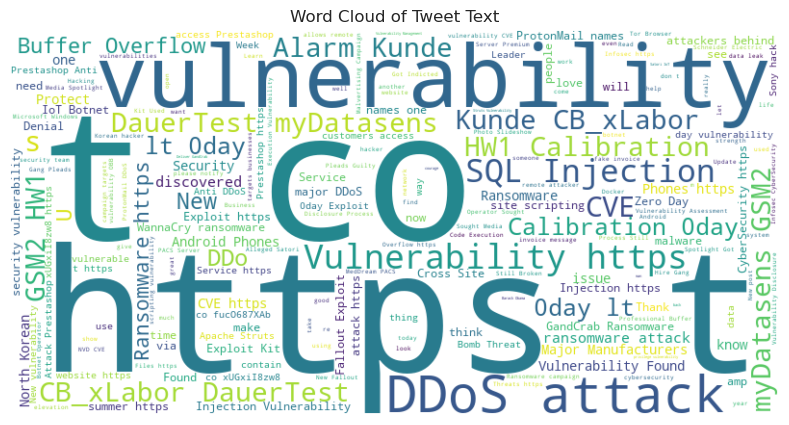

In [10]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(text=' '.join(tweets['text']))

plt.figure(figsize=(15, 5))
plt.imshow(X=wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweet Text')
plt.show()

#### 4.1.3. Text Length Distribution

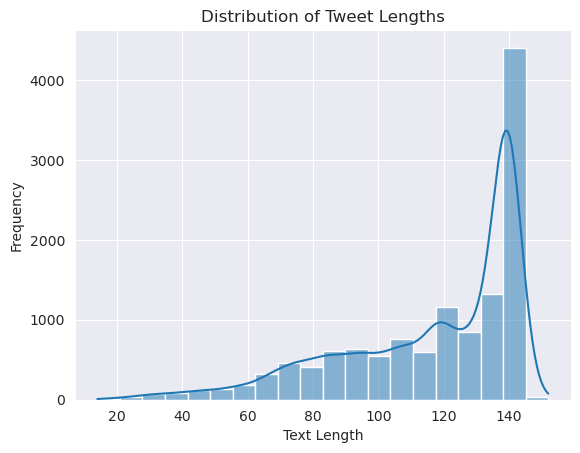

In [11]:
tweets['text_length'] = tweets['text'].apply(func=len)
sns.histplot(
    data=tweets['text_length'],
    bins=20,
    kde=True
)
plt.title(label='Distribution of Tweet Lengths')
plt.xlabel(xlabel='Text Length')
plt.ylabel(ylabel='Frequency')
plt.show()

### 4.3. Watson List Analysis
In the `watson_list` attribute, it is performed category depth, co-occurrence patterns, and top-level category distribution analyses.

In [12]:
# Flatten watson_list and count category frequencies
all_categories = [category for sublist in tweets['watson_list'] for category in sublist]
category_freq = Counter(all_categories)
print("Top 10 Most Frequent Categories:", category_freq.most_common(n=10))

Top 10 Most Frequent Categories: [('technology and computing', 11890), ('computer security', 7501), ('antivirus and malware', 4755), ('software', 3949), ('network security', 3503), ('hardware', 2538), ('society', 2059), ('computer', 1800), ('business and industrial', 1798), ('databases', 1565)]


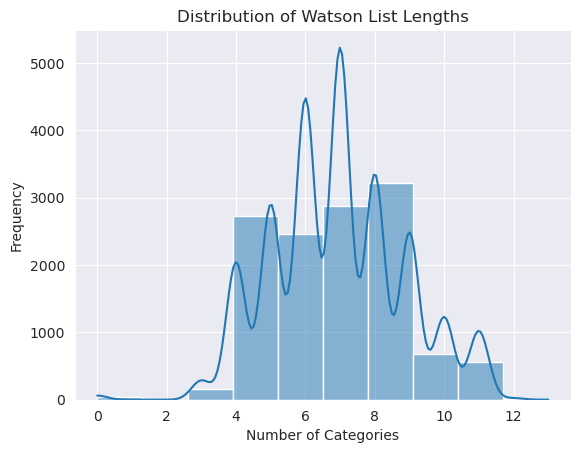

In [13]:
# Category Depth Analysis
tweets['watson_list_length'] = tweets['watson_list'].apply(func=len)

sns.histplot(
    data=tweets['watson_list_length'],
    bins=10,
    kde=True
)

plt.title(label='Distribution of Watson List Lengths')
plt.xlabel(xlabel='Number of Categories')
plt.ylabel(ylabel='Frequency')
plt.show()

In [14]:
# Create co-occurrence matrix
co_occurrence = Counter()
for categories in tweets['watson_list']:
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            co_occurrence[(categories[i], categories[j])] += 1

print("Top 10 Co-occurring Category Pairs:", co_occurrence.most_common(n=10))

Top 10 Co-occurring Category Pairs: [(('technology and computing', 'computer security'), 7501), (('technology and computing', 'antivirus and malware'), 4755), (('computer security', 'antivirus and malware'), 4755), (('technology and computing', 'software'), 3949), (('technology and computing', 'network security'), 3503), (('computer security', 'network security'), 3503), (('technology and computing', 'hardware'), 2538), (('technology and computing', 'computer'), 1800), (('hardware', 'computer'), 1800), (('technology and computing', 'databases'), 1565)]


In [15]:
# Top-Level Category Distribution
top_level_categories = [category.split()[0] for category in all_categories]
top_level_freq = Counter(top_level_categories)
print("Top-Level Category Frequencies:", top_level_freq.most_common())

Top-Level Category Frequencies: [('technology', 11890), ('computer', 10680), ('antivirus', 4755), ('software', 3952), ('network', 3606), ('hardware', 2538), ('society', 2059), ('business', 2012), ('databases', 1565), ('crime', 1506), ('art', 1415), ('law,', 1413), ('consumer', 1243), ('science', 1224), ('operating', 1119), ('health', 1100), ('home', 914), ('personal', 890), ('programming', 860), ('property', 779), ('internet', 615), ('movies', 605), ('hobbies', 575), ('government', 563), ('networking', 552), ('javascript', 493), ('linux', 482), ('vpn', 469), ('finance', 453), ('tv', 441), ('disorders', 423), ('sports', 416), ('telephones', 412), ('legal', 408), ('physics', 408), ('mobile', 406), ('assault', 394), ('travel', 389), ('food', 385), ('optics', 378), ('disease', 374), ('music', 373), ('smart', 372), ('burglary', 371), ('router', 337), ('law', 310), ('windows', 306), ('company', 305), ('mental', 301), ('weather', 291), ('social', 285), ('meteorological', 273), ('kidnapping', 

### 4.4. Target Analysis

Target Frequencies:
computer security: 7501
software: 4294
hardware: 2609
other: 1804
networking: 1130
operating systems: 1119


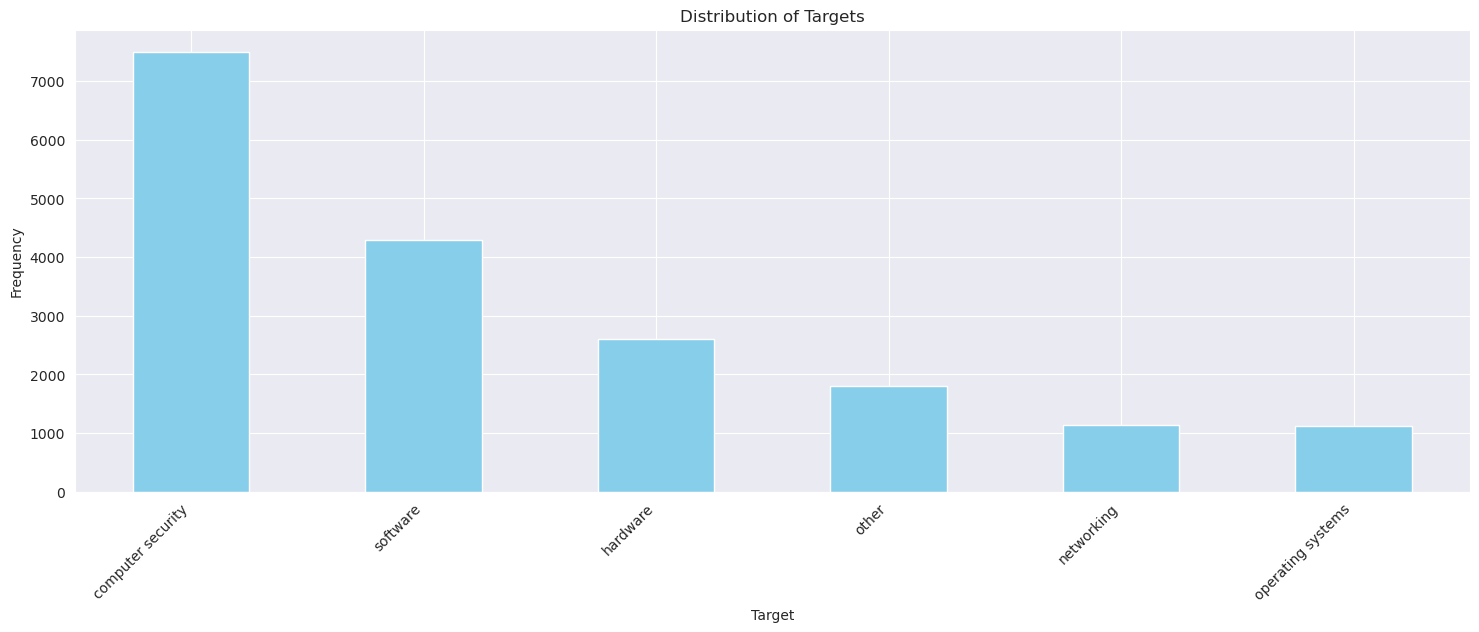

In [16]:
class_freq = Counter([item for sublist in tweets['target'] for item in sublist])

print("Target Frequencies:")
for target, freq in class_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))
pd.Series(data=class_freq).sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

Target Frequencies:
('computer security',): 4125
('other',): 1804
('software', 'computer security'): 1527
('software',): 937
('hardware',): 714
('hardware', 'computer security'): 646
('hardware', 'software'): 430
('operating systems', 'software'): 349
('hardware', 'software', 'computer security'): 328
('networking',): 306
('software', 'networking', 'computer security'): 207
('networking', 'computer security'): 189
('operating systems', 'software', 'computer security'): 178
('operating systems',): 161
('operating systems', 'computer security'): 135
('networking', 'software'): 125
('hardware', 'operating systems', 'software'): 99
('hardware', 'operating systems'): 96
('hardware', 'networking'): 92
('hardware', 'networking', 'computer security'): 72
('hardware', 'operating systems', 'computer security'): 69
('software', 'networking'): 38
('hardware', 'software', 'networking'): 34
('hardware', 'networking', 'software'): 29
('operating systems', 'networking', 'computer security'): 19
('netw

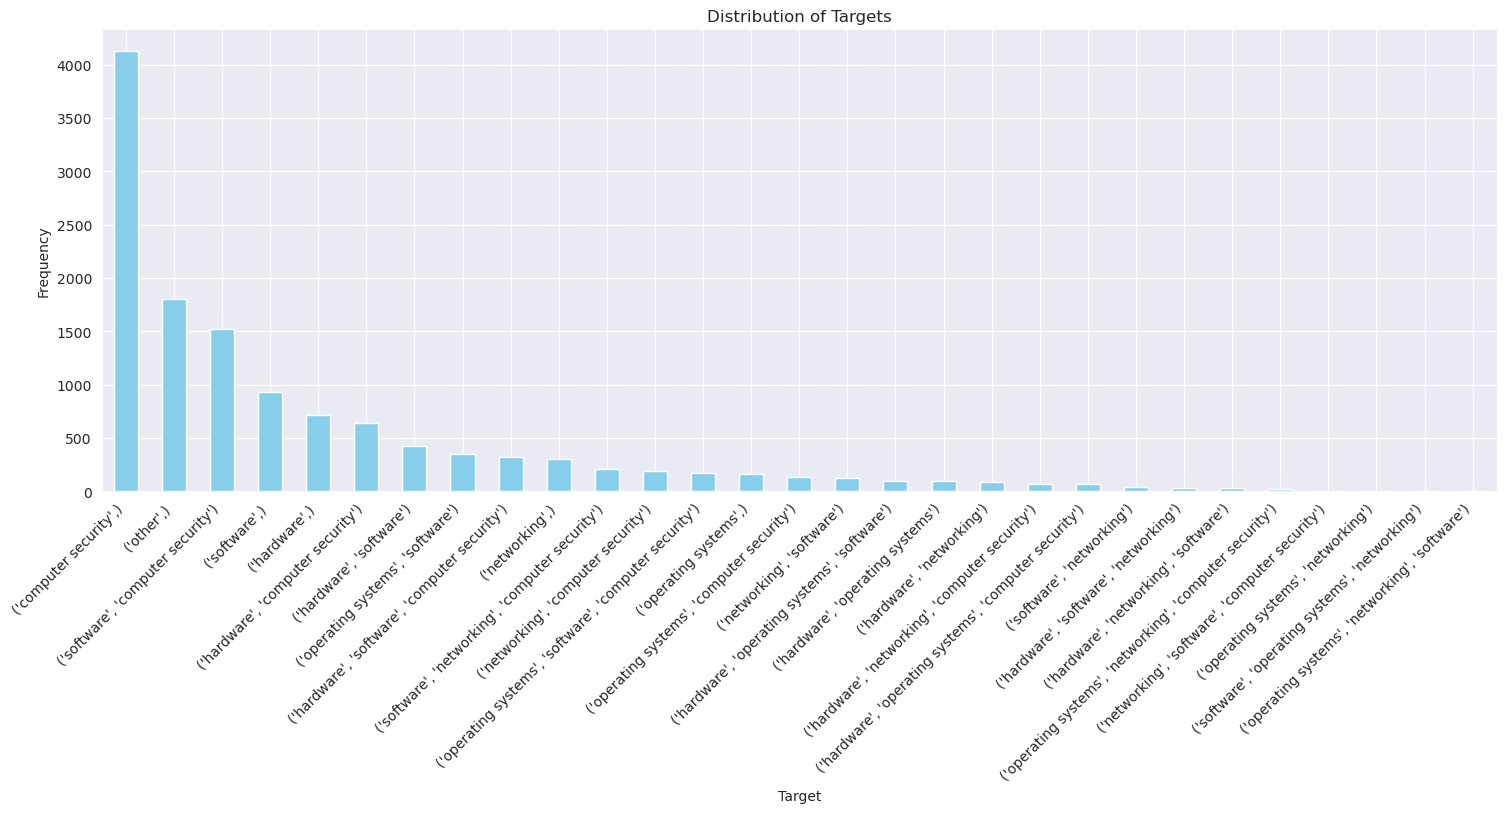

In [17]:
target_freq = Counter(tuple(item) for item in tweets['target'])

print("Target Frequencies:")
for target, freq in target_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))

(pd.Series(data={str(k): v for k, v in target_freq.items()})
 .sort_values(ascending=False)
 .plot(kind='bar', color='skyblue'))

plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

In [18]:
# Multi-Label Analysis
multi_label_counts = tweets['target'].apply(func=lambda x: len(x) > 1).sum()
print(f"Number of tweets with multiple targets: {multi_label_counts}")

Number of tweets with multiple targets: 4681


In [19]:
# Text-Target Relationship
target_text_pairs = [
    (target, text)
    for targets, text in zip(tweets['target'], tweets['text'])
    for target in targets
]

target_text_df = pd.DataFrame(data=target_text_pairs, columns=['target', 'text'])

for target in class_freq:
    target_texts = target_text_df[target_text_df['target'].apply(func=lambda x: target in x)]['text']
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform(raw_documents=target_texts)
    word_freq = pd.Series(data=word_counts.sum(axis=0).A1, index=vectorizer.get_feature_names_out())
    print(f"Top 10 words for target '{target}':")
    print(word_freq.nlargest(10))

Top 10 words for target 'computer security':
https            7180
vulnerability    3594
ddos             1501
ransomware        936
security          851
attack            540
2018              506
cve               498
injection         488
botnet            486
dtype: int64
Top 10 words for target 'other':
https          1572
0day            763
ransomware      581
2018            483
00              406
lt              376
alarm           369
calibration     369
cb_xlabor       369
dauertest       369
dtype: int64
Top 10 words for target 'operating systems':
https            1190
vulnerability     506
2018              259
cve               248
overflow          212
windows           209
buffer            203
microsoft         112
service           112
denial            107
dtype: int64
Top 10 words for target 'software':
https            4656
vulnerability    1979
cve               814
2018              753
injection         539
sql               508
security          496
ransomwa

## 5. Feature Engineering

In [20]:
# Find valid targets (with frequency ≥ 5)
valid_targets = {target for target, freq in target_freq.items() if freq >= 5}

# Filter the DataFrame to keep only valid targets
filtered_df = tweets[tweets['target'].apply(lambda x: tuple(x) in valid_targets)]

# Reset the index (optional)
filtered_df = filtered_df.reset_index(drop=True)

# Print the updated target frequencies
updated_target_freq = Counter(tuple(item) for item in filtered_df['target'])
print("Updated Target Frequencies:")
for target, freq in updated_target_freq.most_common():
    print(f"{target}: {freq}")

Updated Target Frequencies:
('computer security',): 4125
('other',): 1804
('software', 'computer security'): 1527
('software',): 937
('hardware',): 714
('hardware', 'computer security'): 646
('hardware', 'software'): 430
('operating systems', 'software'): 349
('hardware', 'software', 'computer security'): 328
('networking',): 306
('software', 'networking', 'computer security'): 207
('networking', 'computer security'): 189
('operating systems', 'software', 'computer security'): 178
('operating systems',): 161
('operating systems', 'computer security'): 135
('networking', 'software'): 125
('hardware', 'operating systems', 'software'): 99
('hardware', 'operating systems'): 96
('hardware', 'networking'): 92
('hardware', 'networking', 'computer security'): 72
('hardware', 'operating systems', 'computer security'): 69
('software', 'networking'): 38
('hardware', 'software', 'networking'): 34
('hardware', 'networking', 'software'): 29
('operating systems', 'networking', 'computer security'): 1

Preprocess the `text` column into embeddings

In [21]:
def load_word2vec_dict(model_path: Path, embedding_dim: int) -> dict[Union[str, list[str]], np.ndarray[Any, np.dtype]]:
    embeddings_dict = {}

    f = open(model_path, 'r', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[:-embedding_dim]

        if type(word) is list:
            word = ' '.join(word)

        vector = asarray([float(val) for val in values[-embedding_dim:]])
        embeddings_dict[word] = vector
    f.close()

    return embeddings_dict


def tokenizer_transform(
        x: pd.Series,
        embedder_addr: str,
        preprocessing_list: Optional[list[Callable[[str], str]]] = None,
) -> np.ndarray[Any, np.dtype[Any]]:
    """
    Generate embeddings for the sentences in the DataFrame.

    Args:
        x (pd.Series): The DataFrame containing the sentences.
        embedder_addr (str): Address of the embedder.
        preprocessing_list (list[callable]): List of functions to apply to each sentence.
    """
    # Preprocess the text
    sentences = x.tolist()

    if preprocessing_list is None:
        preprocessing_list = []

    for preprocessor in preprocessing_list:
        sentences = [preprocessor(s) for s in sentences]

    model = SentenceTransformer(model_name_or_path=embedder_addr)
    return model.encode(sentences)


def preprocess_texts(list_str, model_path, embedding_dim):
    if embedding_dim is None:
        return tokenizer_transform(
            x=list_str,
            embedder_addr=model_path
        )

    word2vec_dict = load_word2vec_dict(
        model_path=model_path,
        embedding_dim=embedding_dim
    )
    list_embedded_str = np.zeros((len(list_str), embedding_dim))

    for i, text in enumerate(list_str):
        tokens = re.findall(r'\w+|[{}]'.format(re.escape(string.punctuation)), text)

        for token in tokens:
            try:
                list_embedded_str[i] += word2vec_dict[token.lower()]
            except KeyError:
                continue

    return list_embedded_str


texts = filtered_df['text']
x = preprocess_texts(
    list_str=texts,
    model_path='basel/ATTACK-BERT',
    embedding_dim=None
)
#X = preprocess_texts(list_str=filtered_df['text'], model_path=GLOVE_6B_300D_TXT, embedding_dim=300)

Convert the `target` column into a binary multi-label matrix

In [22]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y=filtered_df['target'])

Create a dictionary that maps label indices to unique label sets

In [23]:
targets_list_mcp, y_mcp = np.unique(ar=y, axis=0, return_inverse=True)
targets_dict_mcp = {i: tuple(lbl_set) for i, lbl_set in enumerate(targets_list_mcp)}

## 6. Model Training

In [24]:
# BR, CLR, CC, CDN, MBR, LP
X_train, X_val, y_train, y_val, y_train_mcp, y_val_mcp = train_test_split(
    x, y, y_mcp,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_mcp
)

print(
    f"{'Training:':<15}\tX = {str(X_train.shape[0]) + ' × ' + str(X_train.shape[1]):<15}\ty = {str(y_train.shape[0]) + ' × ' + str(y_train.shape[1]):<15}")
print(
    f"{'Validation:':<15}\tX = {str(X_val.shape[0]) + ' × ' + str(X_val.shape[1]):<15}\ty = {str(y_val.shape[0]) + ' × ' + str(y_val.shape[1]):<15}")

Training:      	X = 10180 × 768    	y = 10180 × 6      
Validation:    	X = 2546 × 768     	y = 2546 × 6       


In [26]:
br = BRClassifier(RandomForestClassifier())
br.fit(X_train, y_train)
br.evaluate(X_val, y_val)

{'accuracy': 0.6300078554595444,
 'f1_micro': 0.7978644520243215,
 'hamming_loss': 0.08922492799162084}

In [33]:
model = CLRClassifier(RandomForestClassifier())
model = model.fit(X_train, y_train)
model.evaluate(X_val, y_val)

{'accuracy': 0.0,
 'f1_micro': 0.3752316441945172,
 'hamming_loss': 0.6400235663786331}

In [35]:
cc = CCClassifier(RandomForestClassifier())
cc.fit(X_train, y_train)
cc.evaluate(X_val, y_val)

{'accuracy': 0.6362922230950511,
 'f1_micro': 0.7998815867377146,
 'hamming_loss': 0.08850484420005238}

In [39]:
lp = LPClassifier(RandomForestClassifier())
lp.fit(X_train, y_train)
lp.evaluate(X_val, y_val)

{'accuracy': 0.6747839748625295,
 'hamming_loss': 0.09518198481277822,
 'f1_micro': 0.7944585807181227}

In [43]:
pst = PStClassifier(XGBClassifier())
pst.fit(X_train, y_train)
pst.evaluate(X_val, y_val)

{'accuracy': 0.683032207384132,
 'hamming_loss': 0.09086148206336737,
 'f1_micro': 0.8058741258741259}

In [43]:
cdn = CDNClassifier(RandomForestClassifier())
cdn.fit(X_train, y_train)
cdn.evaluate(X_val, y_val)

KeyboardInterrupt: 

In [41]:
mbr = MBRClassifier(RandomForestClassifier())
mbr.fit(X_train, y_train)
mbr.evaluate(X_val, y_val)

{'accuracy': 0.6417910447761194,
 'f1_micro': 0.8070848708487085,
 'hamming_loss': 0.08555904687090861}

In [49]:
rakel = RAkELClassifier(RandomForestClassifier())
rakel.fit(X_train, y_train)
rakel.evaluate(X_val, y_val)

{'accuracy': 0.6488609583660644,
 'hamming_loss': 0.09073055773762766,
 'f1_micro': 0.7979002624671916}

In [67]:
homer = HOMERClassifier(RandomForestClassifier())
homer.fit(X_train, y_train)
homer.evaluate(X_val, y_val)

{'accuracy': 0.6398271798900236,
 'hamming_loss': 0.0884393820371825,
 'f1_micro': 0.8026296566837108}